In [119]:
import string
import os
from PIL import Image
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.applications.xception import Xception
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

# Getting the data and performing data cleaning

In [120]:
# For loading the document file and reading the contents inside the file into a string
def load_document(filename):
    # Opening the file as read only
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [121]:
# Get all images with their captions
def all_images_captions(filename):
    file = load_document(filename)
    captions = file.split('\n')
    descriptions = {} # Dictionary that maps images with a list of 5 captions
    
    for caption in captions[:-1]: # The last line is an empty line
        image, caption = caption.split('\t')
        if image[:-2] not in descriptions:
            descriptions[image[:-2]] = [caption] # Adding the image name as the dictionary key and the 5 caption as a list of values
        else:
            descriptions[image[:-2]].append(caption)

    return descriptions

In [122]:
# Function takes all descriptions and performs data cleaning
def cleaning_captions(descriptions):
    table = str.maketrans('', '', string.punctuation) # Translation table for removing punctuation from strings
    for image, captions in descriptions.items():
        for index, caption in enumerate(captions):
            # Remove dash (-) from caption
            caption.replace('-', ' ')
            desc = caption.split()
            
            # Convert to lowercase
            desc = [word.lower() for word in desc]
            
            # Remove punctuation
            desc = [word.translate(table) for word in desc]
            
            # Remove hanging 's and a
            desc = [word for word in desc if (len(word) > 1)]
            
            # Remove words with numbers in them
            desc = [word for word in desc if (word.isalpha())]
            
            # Convert back to string
            caption = ' '.join(desc)
            
            descriptions[image][index] = caption
    return descriptions

In [123]:
# Function that will separate all the unique words and create the vocabulary from all the captions
def text_vocabulary(descriptions):
    vocabulary = set()
    
    for key in descriptions.keys():
        [vocabulary.update(caption.split()) for caption in descriptions[key]]
    
    return vocabulary

In [124]:
# Create a list of all the descriptions that have been preprocessed and store them into a file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [125]:
# Path to the data files
dataset_text = "A:/AMRO/1programming/DS, ML, DL, statistics/projects/Image Caption Generator/Flickr8k_text"
dataset_images = "A:/AMRO/1programming/DS, ML, DL, statistics/projects/Image Caption Generator/Flicker8k_Dataset"

In [126]:
# Loading the file that contains all data
filename = dataset_text + "/" + "Flickr8k.token.txt"

In [127]:
# Mapping them into descriptions dictionary img to 5 captions
descriptions = all_images_captions(filename)
print(f'Length of descriptions: {len(descriptions)}')

Length of descriptions: 8092


In [128]:
# Cleaning the descriptions
clean_descriptions = cleaning_captions(descriptions)

In [129]:
# Building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print(f'Length of vocabulary: {len(vocabulary)}')

Length of vocabulary: 8763


In [130]:
# Saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

# Extracting the feature vector from all images

In [131]:
# Extract features for all images
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img in os.listdir(directory):
        filename = directory + '/' + img
        image = Image.open(filename)
        
        # Preprocess the input image
        image = image.resize((299, 299)) # Resize to Xception's default input size
        image = np.expand_dims(image, axis=0) # Add an extra dimension to the array to represent the batch size, because Xception is designed to process images in batches
        # Range of pixel values [-1, 1]
        image = image / 127.5
        image = image - 1.0
        
        feature = model.predict(image)
        features[img] = feature
    
    return features

In [132]:
#features = extract_features(dataset_images)

In [133]:
# Save features in a pickled file
#pickle.dump(features, open("features.p","wb"))

In [134]:
features = pickle.load(open("features.p","rb"))

# Loading dataset for Training the model

In [135]:
# Load the text file in a string and will return the list of image names
def load_photos(filename):
    file = load_document(filename)
    photos = file.split('\n')[:-1] # The last line is an empty line
    return photos

In [136]:
# Create a dictionary that contains captions for each photo from the list of photos
def load_clean_descriptions(filename, photos):
    file = load_document(filename)
    descriptions = {}
    
    for line in file.split('\n'):
        words = line.split()
        
        if len(words) < 1: # To check for empty lines
            continue
        
        image, image_cpation = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            
            # Append the <start> and <end> identifier for each caption
            # So that LSTM model can identify the starting and ending of the caption
            desc = '<start> ' + ' '.join(image_cpation) + ' <end>' 
            descriptions[image].append(desc)
    
    return descriptions

In [137]:
# Give the dictionary for image names and their feature vector
def load_features(photos):
    # Load all features
    all_features = pickle.load(open('features.p', 'rb'))
    
    # Selecting only needed features
    features = {k:all_features[k] for k in photos}
    
    return features

In [138]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

In [139]:
train_imgs = load_photos(filename)

In [140]:
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

In [141]:
train_features = load_features(train_imgs)

# Tokenizing the vocabulary
To represent words with numbers
Map each word of the vocabulary with a unique index value

In [142]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    
    return all_desc

In [143]:
# Function to create a Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [144]:
# Give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
pickle.dump(tokenizer, open('tokenizer.p', 'wb'))

In [145]:
vocab_size = len(tokenizer.word_index) + 1 # Number of distinct words
vocab_size

7577

In [146]:
# trying the Tokenizer
tokenizer.texts_to_sequences(['<start> child in pink dress is climbing up set of stairs in an entry way <end>'])

[[2, 42, 3, 87, 169, 6, 117, 55, 393, 11, 394, 3, 27, 4472, 639, 1]]

In [147]:
tokenizer.sequences_to_texts([[2,42,3,87,169,6,117,55,393,11,394,3,27,4472,639,1]])

['start child in pink dress is climbing up set of stairs in an entry way end']

In [148]:
# Calculate maximum length of descriptions
# This is important for deciding the model structure parameters
# While it's true that RNNs can handle variable-length input sequences
# In practice RNNs, benefit from having fixed-length input sequences

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

# Create Data generator
To make this task into a supervised learning task
I have to provide input and output to the model for training
The input to the model is [x1, x2] and the output will be y
where
* x1 is the 2048 feature vector of that image
* x2 is the input text sequence
* y is the output text sequence -the next word in the sequence- that the model has to predict.

In [149]:
def create_sequences(tokenizer, max_length, decs_list, feature):
    X1, X2, y = [], [], []
    
    # Walk through each description for the image
    for desc in decs_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # Split sequence into X, y pairs
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            # Pads the input sequence to ensure it has a fixed length of max_length
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0] # max_length = 32
            # Converts the output sequence to a one-hot encoded format with a vocabulary size of vocab_size
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # vocab_size = 7577
            
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
            
    return np.array(X1), np.array(X2), np.array(y)

In [150]:
# This function is a generator that continuously yields batches of training data
# Used by model.fit_generator()
# model.fit_generator is used when we have a huge dataset
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0] # The 2048 feature vector of that image
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [151]:
# Check the shape of the input and output for the model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

# Defining the CNN-RNN model

In [152]:
# Define the model
def define_model(vocab_size, max_length):
    
    # Features from the CNN model
    input1 = keras.layers.Input(shape=(2048, )) # The 2048 feature vector of the image
    x = keras.layers.Dropout(0.5)(input1) # Dropout is a regularization technique used to prevent overfitting
    x = keras.layers.Dense(256, activation='relu')(x)
    
    # LSTM sequence model
    input2 = keras.layers.Input(shape=(max_length, ))
    # An embedding is a trainable dense vector that represents a category
    # mask_zero=True ==> the model will ignore padded values
    y = keras.layers.Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input2)
    y = keras.layers.Dropout(0.5)(y) # Dropout is a regularization technique used to prevent overfitting
    y = keras.layers.LSTM(256)(y)
    
    # Merging the output from the above two layers
    merge = keras.layers.add([x, y])
    merge = keras.layers.Dense(256, activation='relu')(merge)
    output = keras.layers.Dense(vocab_size, activation='softmax')(merge)
    
    model = keras.models.Model(inputs=[input1, input2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

# Training the model

In [153]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


In [154]:
model = define_model(vocab_size, max_length)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 32)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 32, 256)              1939712   ['input_21[0][0]']            
                                                                                                  
 dropout_4 (Dropout)         (None, 2048)                 0         ['input_20[0][0]']            
                                                                                            

In [155]:
epochs = 10
steps = len(train_descriptions)

In [156]:
# Making a directory  to save the models
# os.mkdir("models")

In [157]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save("models/model_" + str(i) + ".h5")

# Testing the model

In [158]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        
        # Preprocess the image
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [159]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
         if index == integer:
             return word
    return None

In [160]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

1/1 [==============================] - 1s 784ms/step



start man is climbing up rock face end


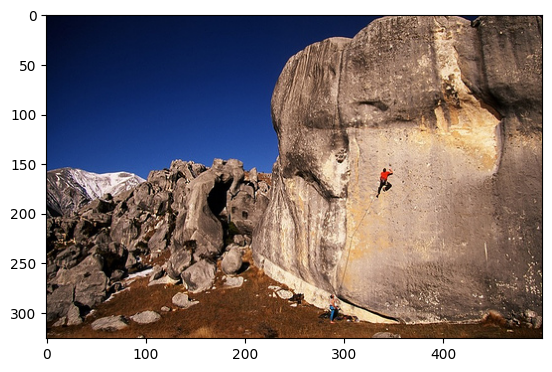

In [161]:
path = 'Flicker8k_Dataset/405534993_5158644f98.jpg'
max_length = 32
tokenizer = pickle.load(open("tokenizer.p","rb"))

model = keras.models.load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(path, xception_model)
img = Image.open(path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 125ms/step



start white dog is running through the water end


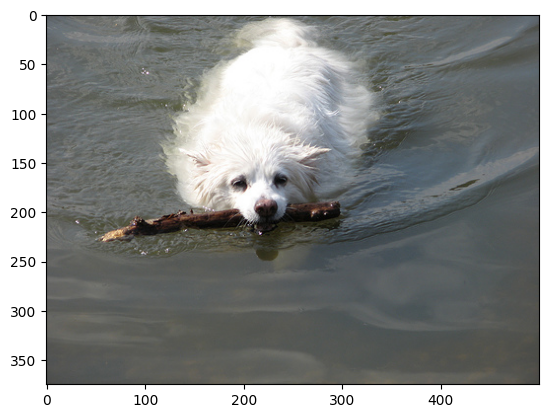

In [162]:
path = 'Flicker8k_Dataset/475980315_b8ecd50094.jpg'

photo = extract_features(path, xception_model)
img = Image.open(path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 141ms/step



start two dogs are running through the snow end


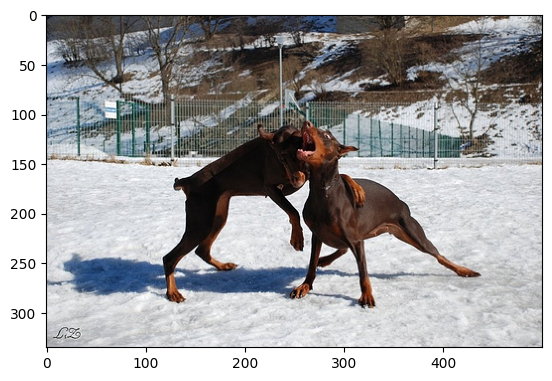

In [163]:
path = 'Flicker8k_Dataset/3385593926_d3e9c21170.jpg'

photo = extract_features(path, xception_model)
img = Image.open(path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 141ms/step



start man in black shirt and hat is standing on street with people look on end


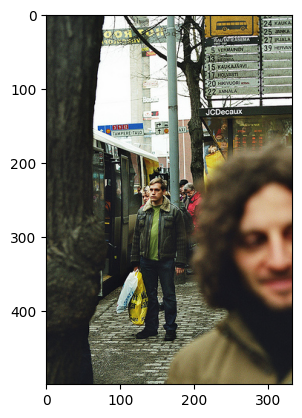

In [164]:
path = 'Flicker8k_Dataset/3344233740_c010378da7.jpg'

photo = extract_features(path, xception_model)
img = Image.open(path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)